<img src="http://www3.ifmg.edu.br/site_campi/p/images/logos/Betim-Simples.png" width="700"></img>
<b>Engenharia de Controle e Automação - Redes neurais artificiais</b> - Prof. Leandro Freitas

### Lucas Pevidor Reis - 0024855 - TP2

# 1  Objetivo

Implementar uma rede neural Perceptron de única camada para fazer classificação entre duas classes distintas.


# 2 Classificação de classes de veículos

## 2.1 Importação de bibliotecas e configuração do matplotlib:

In [224]:
%matplotlib inline

import numpy as np
import random
from matplotlib import pyplot as plt

## 2.2 Importação e verificação dos dados de entradas

In [225]:
Carro1 = np.empty((10,3), dtype=float)
Carro2 = np.empty((10,3), dtype=float)

#Ford Fusion
Carro1[0] = [17058, 99900, -1]
Carro1[1] = [16000, 103900, -1]
Carro1[2] = [44667, 104990, -1]
Carro1[3] = [47000, 107900, -1]
Carro1[4] = [19726, 124990, -1]
Carro1[5] = [19826, 116900, -1]
Carro1[6] = [17700, 118900, -1]
Carro1[7] = [28204, 119890, -1]
Carro1[8] = [17000, 120950, -1]
Carro1[9] = [22000, 123900, -1]

#Fiat Uno
Carro2[0] = [29501, 34000, 1]
Carro2[1] = [42067, 33440, 1]
Carro2[2] = [34109, 31100, 1]
Carro2[3] = [34713, 31300, 1]
Carro2[4] = [27912, 32499, 1]
Carro2[5] = [28272, 31990, 1]
Carro2[6] = [26733, 32990, 1]
Carro2[7] = [24990, 33660, 1]
Carro2[8] = [16000, 33800, 1]
Carro2[9] = [15000, 35900, 1]

Entradas = np.append(Carro1[:,:2], Carro2[:,:2], axis=0)
Saida_desejada = np.transpose([np.append(Carro1[:,2], Carro2[:,2], axis=0)])

Para que uma rede Percéptron consiga distinguir as classes, elas devem ser linearmente separáveis. 

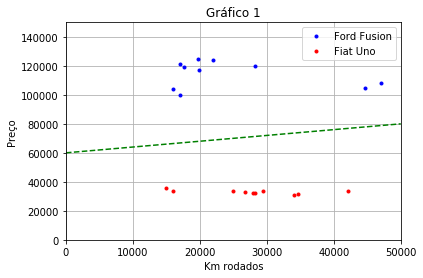

In [226]:
plt.figure()
plt.plot(Carro1[:,0], Carro1[:,1], '.b', label='Ford Fusion')
plt.plot(Carro2[:,0], Carro2[:,1], '.r', label='Fiat Uno')
plt.plot([0,50000], [60000, 80000], '--g')
plt.axis([0,50000,0,150000])
plt.grid(True)
plt.xlabel('Km rodados')
plt.ylabel('Preço')
plt.title('Gráfico 1')
plt.legend()
plt.show()

Conforme mostrado no Gráfico 1, é possível separar os dois carros utilizando uma reta. Portanto, é possível criar uma rede Percéptron capaz de distinguir os dois carros.

Foi desenvolvida uma função para fazer a plotagem automaticamente, apresentada abaixo:

In [227]:
def plotarGrafico(entradas, s_desejada, pesos, titulo):
    plt.figure(figsize=(4,4))
    for i, el in enumerate(entradas):
        if s_desejada[i,0] == -1:
            plt.plot(el[0], el[1], '.b')
        else:
            plt.plot(el[0], el[1], '.r')

    plt.title(titulo)
    
    if pesos is not None:
        x1 = np.array([-2.1, 2.1])
        x2 = (-1*x1*pesos[0,0])/pesos[1,0]
        plt.plot(x1, x2, '--g')
        
        peso_modulo = np.sqrt(pesos[0,0]**2 + pesos[1,0] ** 2)
        pesos = pesos/peso_modulo
        plt.plot([0, pesos[0,0]], [0, pesos[1,0]])
    plt.show()

## 2.3 Implementação da rede neural

Optou-se por realizar a implementação da rede neural utilizando classes, visto que facilita o processo de desenvolvimento.

In [228]:
class Perceptron:
    #Função de inicialização da classe
    def __init__(self, n_entradas, func_act, use_bias):
        #Se optar por utilizar bias, será adicionada uma coluna no final dos vetores de entrada com valor unitário.
        self.use_bias = use_bias        
        if use_bias:
            self.pesos = np.empty((n_entradas+1, 1), dtype=float)
        else:
            self.pesos = np.empty((n_entradas, 1), dtype=float)
        self.func_act = func_act   
    
    def reset(self):
        #Zerar pesos
        self.pesos = np.zeros((len(self.pesos[:,0]), 1), dtype=float)
            
    #Definição de entradas
    #Função utilizada para configurar o vetor de entrada interno da classe, juntamente com normalização, adição
    #da coluna de bias. Utilizar quando a média e desvpad para normalização ainda não foram definidos.
    def set_entradas_ant(self, entradas, normalizar):        
        if self.use_bias:
            vetor_1 = np.zeros([len(entradas[:,0]), 1]) + 1
            if normalizar:
                self.normalizar(entradas, False)
                self.vetor_entradas = np.append(self.entr_normalizada, vetor_1, axis=1)
            else:
                self.vetor_entradas = np.append(entradas, vetor_1, axis=1)
        else:
            if normalizar:                
                self.vetor_entradas = self.normalizar(entradas, False)
            else:
                self.vetor_entradas = entradas
    
    #Definir entradas após treinamento da rede
    #Função utilizada para configurar o vetor de entrada interno da classe, juntamente com normalização, adição
    #da coluna de bias. Utilizar quando a média e desvpad para normalização ainda JÁ foram definidos.
    def set_entradas_pós(self, entradas, normalizar):
        if self.use_bias:
            vetor_1 = np.zeros([len(entradas[:,0]), 1]) + 1
            if normalizar:            
                self.vetor_entradas = np.append(self.normalizar(entradas, True), vetor_1, axis=1)
            else:
                self.vetor_entradas = np.append(entradas, vetor_1, axis=1)
        else:
            if normalizar:
                self.vetor_entradas = self.normalizar(entradas, True)
            else:                    
                self.vetor_entradas = entradas
    
    def normalizar(self, entradas, utilizar_parametros_anteriores):
        if utilizar_parametros_anteriores == False:
            #Encontrar média e desvio padrão a partir das entradas fornecidas.
            #Executado antes do treinamento da rede
            self.media = np.empty(len(entradas[0,:]), dtype=float)
            self.desvpad = np.empty(len(entradas[0,:]), dtype=float)
            self.entr_normalizada = np.empty((len(entradas[:,0]), len(entradas[0,:])), dtype=float)
        
            for i in range(0, len(entradas[0,:])):
                self.media[i] = np.mean(entradas[:,i])
                self.desvpad[i] = np.sqrt(np.var(entradas[:,i]))            
                self.entr_normalizada[:,i] = (entradas[:,i] - self.media[i] ) / self.desvpad[i]
            return self.entr_normalizada
        else:
            #Normaliza os dados de entrada fornecidos conforme a média e desvio padrão já encontrados anteriormente
            entr_nova_normalizada = np.empty((len(entradas[:,0]), len(entradas[0,:])), dtype=float)
            for i in range(0, len(entradas[0,:])):                
                entr_nova_normalizada[:,i] = (entradas[:,i] - self.media[i] ) / self.desvpad[i]            
            
            return entr_nova_normalizada    
        
    def proc_saida(self, entradas, normalizado):
        if not normalizado:
            #Normalização das entradas utilizando média e desvpad já encontrados
            entr_nova_normalizada = self.normalizar(entradas, True)
        else:
            entr_nova_normalizada = entradas
        
        v = np.dot(entr_nova_normalizada, self.pesos)
        if(self.func_act == 'Bipolar'):
            saida = np.empty([1,1])            
            for i in range(len(v)):
                if(v[i,:] > 0):
                    saida = np.append(saida, [[1]], axis=0)
                else:
                    saida = np.append(saida, [[-1]], axis=0)
            self.saida = saida[1:]
            return saida[1:]
            
    def treinar_rede(self, fator_aprendizado, saida_desejada, max_iterações, plot):
        redeTreinada = False
        self.historicoAcertos = []
        self.historicoPesos = np.empty([len(self.pesos), 1])
        
        for i in range(0, max_iterações):
            if not redeTreinada:
                flagAlteração = False
                acertos = 0
                for j in range(len(self.vetor_entradas[:,0])):
                    #Testa as entradas até encontrar um erro
                    #Caso encontrado, continua testando as outras entradas para obter a quantidade de acertos para
                    #os pesos atuais. Em seguida atualiza os pesos e reinicia os testes.
                    res = saida_desejada[j,0] - self.proc_saida([self.vetor_entradas[j,:]], True)[0,0]
                    if res == 0:
                        acertos += 1
                    else:
                        deltaW = fator_aprendizado * res * self.vetor_entradas[j,:]                    
                        flagAlteração = True
                        
                        if plot:
                            plotarGrafico(self.vetor_entradas, saida_desejada, self.pesos, '')
                        
                        #Termina de checar a quantidade de acertos
                        #antes de atualizar os pesos
                        for k in range(j+1, len(self.vetor_entradas[:,0])):
                            res = saida_desejada[k,0] - self.proc_saida([self.vetor_entradas[k,:]], True)[0,0]
                            if res == 0:
                                acertos += 1
                        
                        #Salva os acertos e pesos
                        self.historicoAcertos.append(acertos)
                        self.historicoPesos = np.append(self.historicoPesos, self.pesos, axis=1)
                        
                        #Atualiza os pesos                               
                        self.pesos += np.transpose([deltaW])
                        break
                
                if flagAlteração == False:
                    redeTreinada = True
                    self.historicoAcertos.append(acertos)
                    self.historicoPesos = np.append(self.historicoPesos, self.pesos, axis=1)
                    if plot:
                        plotarGrafico(self.vetor_entradas, saida_desejada, self.pesos, '')
        
        self.historicoErros = []
        for i in range(len(self.historicoAcertos)):            
            self.historicoErros.append(len(self.vetor_entradas) - self.historicoAcertos[i])
        
        if redeTreinada == False:
            #Se não foi possível obter 100% de acerto durante as iterações
            #encontra e define como pesos os que obtiveram mais acertos
            indiceMax = self.historicoAcertos.index(max(self.historicoAcertos))                        
            self.pesos = np.transpose([self.historicoPesos[:, indiceMax+1]])
            print('Nº erros: {}'.format(len(self.vetor_entradas[:,0])-max(self.historicoAcertos)))

### 2.3.1 - Implementação da função de normalização

Antes de entrar com os dados de entrada na rede Percéptron eles devem ser normalizados. A normalização dos dados foi implementada utilizando o método do desvio padrão, dado pela fórmula:

$x_{norm} = \frac{x - m}{\sigma}$

onde $m$ é a média dos valores das entradas e $\sigma$ é o desvio padrão das amostras.

![Norm](https://i.imgur.com/IqjKXuY.png)

Na função implementada existe a possibilidade de a partir de um array de entradas, obter sua média e desvio padrão e normalizá-lo, e a possibilidade de obter sua normalização partindo de uma média e desvio padrão já obtidos anteriormente. Porém, este processo é gerenciado pelas funções *set_entrada*, portanto não é necessário chamar este método por fora da classe.

### 2.3.2 - Implementação do processo de obtenção da saída da rede neural

A saída $y$ da rede neural pode ser obtida a partir das seguintes equações:

![](https://i.imgur.com/KDS3pA9.png =100x50)

Onde $w_i$ é o vetor de pesos e $x_i$ o vetor de entradas. $\varphi$ é a função de ativação.
![proc_saida](https://i.imgur.com/2OzB34o.png)

### 2.3.3 - Implementação do algoritmo de treinamento da rede neural

O algoritmo de treinamento funciona conforme as equações:

$w(n+1) = w(n) + \Delta w$

$\Delta w = \eta (d(n)-y(n))x(n)$

A função de treinamento recebe como argumentos o fator de aprendizado $\eta$, o vetor de saídas desejadas e um número inteiro que representa a quantidade limite de iterações a serem executadas pelo algoritmo. No caso de não haver uma solução ótima para a separação dos dados de entrada o algoritmo seleciona a solução que obteve mais acertos durante o processo. O último argumento é utilizado para plotar o ajuste de pesos durante a fase de treinamento, que deve ser utilizado somente no caso de haverem 2 entradas na rede neural.

![treinar1](https://i.imgur.com/mDzn0RE.png)
![treinar2](https://i.imgur.com/qV1GSWb.png)

## 2.4 - Inicialização da rede neural

Como a rede neural está sendo implementada em uma classe, é necessário instanciá-la primeiramente:

In [229]:
rede1 = Perceptron(n_entradas=2, func_act='Bipolar', use_bias=False)

## 2.5 - Normalização dos dados de entrada

Com a rede já inicializada é necessário realizar a normalização dos dados de entrada. Isto é feito automaticamente ao chamar a função de importação de entradas da classe Perceptron. As entradas ficam armazenadas no objeto *rede1*, nas variáveis *entr_normalizada* e *vetor_entradas*.

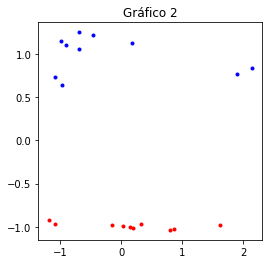

In [230]:
rede1.set_entradas_ant(Entradas, normalizar=True)

plotarGrafico(rede1.vetor_entradas, Saida_desejada, None, 'Gráfico 2')

## 2.6 Vetor de pesos para separação dos dados

Observando o Gráfico 2 conclui-se que para separar os dados pode-se utilizar um vetor $(0, -0.5)$. Com o vetor nesta forma, a saída desejada se torna 1 para os Fiat Uno e -1 para os Ford Fusion.

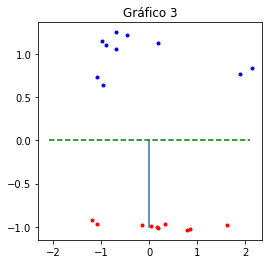

In [231]:
w = np.array([[0],[-0.5]])

plotarGrafico(rede1.entr_normalizada, Saida_desejada, w, 'Gráfico 3')

## 2.7 Execução do algoritmo de aprendizagem

Execução do treinamento para 5 amostras de 8 elementos:

Amostra 1:


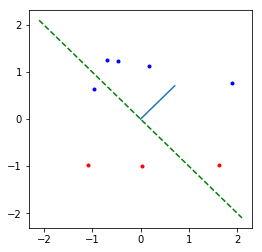

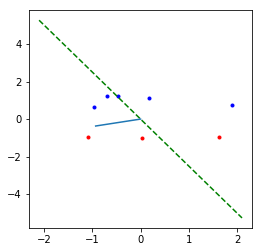

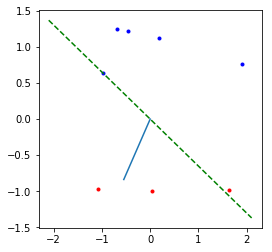

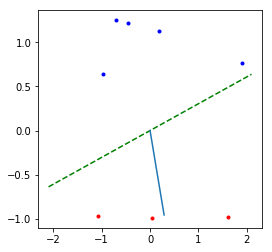

Amostra 2:


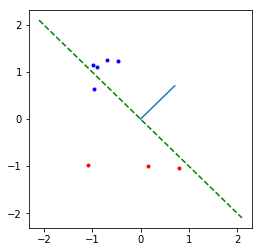

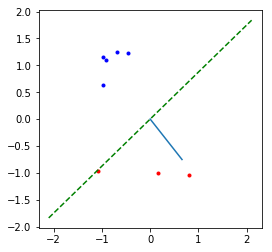

Amostra 3:


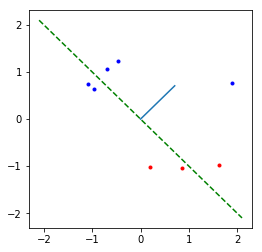

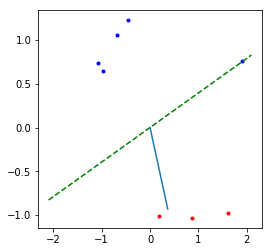

Amostra 4:


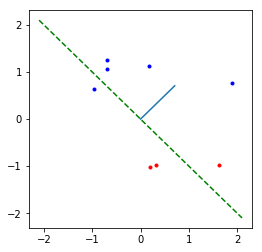

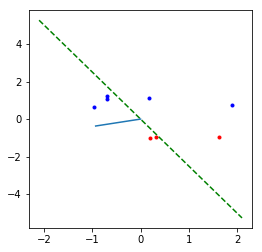

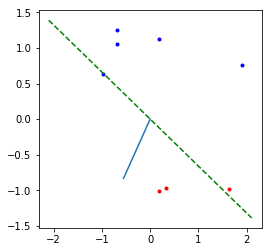

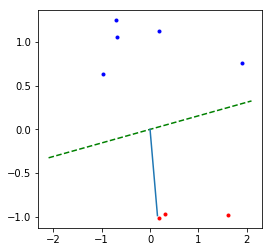

Amostra 5:


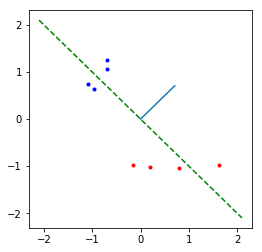

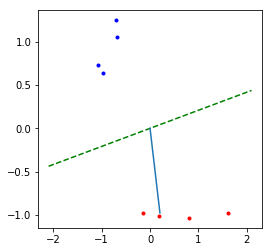

In [259]:
n_amostras = 8
vet_ent = np.empty([n_amostras,2])   #Vetor de amostras de entrada
vet_sdesejadas = np.empty([n_amostras,1])
lista_erros = []

#Geração de amostras e treinamento da rede para fator de aprendizagem = 0.3
for n in range(5):
    k=0
    print('Amostra {}:'.format(n+1))
    for i in random.sample(range(0,19), n_amostras):    
        vet_ent[k] = rede1.entr_normalizada[i]
        vet_sdesejadas[k,0] = Saida_desejada[i,0]        
        #print('{} - {}: {}'.format(vet_ent[k], vet_sdesejadas[k], i))
        k += 1
    
    rede1.set_entradas_pós(vet_ent, False)
    rede1.pesos = np.array([[0.01],[0.01]]) #Array de pesos [0, 0] resulta em erro de divisão por 0
    rede1.treinar_rede(0.3, vet_sdesejadas, 30, True)
    
    lista_erros.append(rede1.historicoErros)

Comparando o desempenho do treinamento da rede para as amostras geradas:

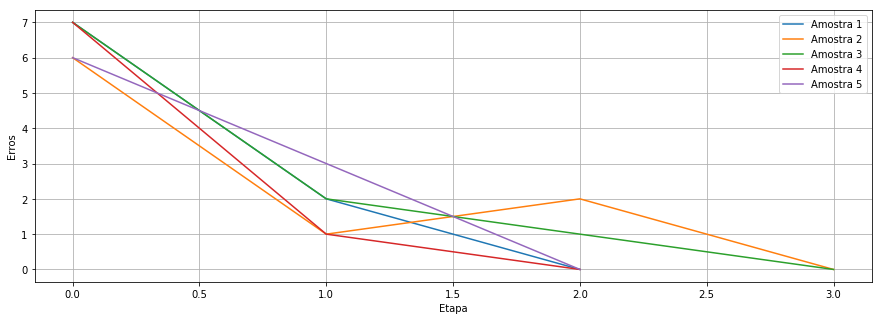

In [233]:
plt.figure(figsize=(15,5))
for k in range(5):
    plt.plot(lista_erros[k], label='Amostra {}'.format(k+1))
plt.xlabel('Etapa')
plt.ylabel('Erros')
plt.legend()
plt.grid(True)
plt.show()

Testando para fator de aprendizagem = 2:

Amostra 1:


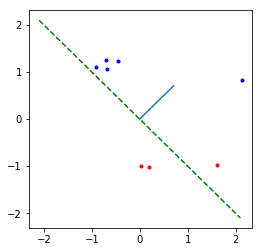

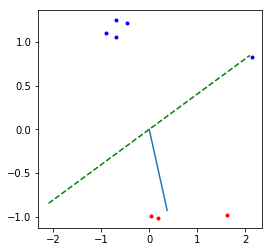

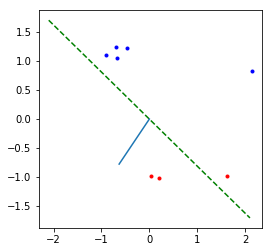

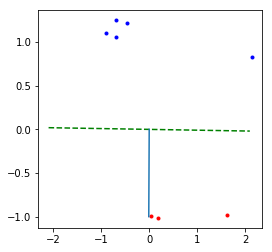

Amostra 2:


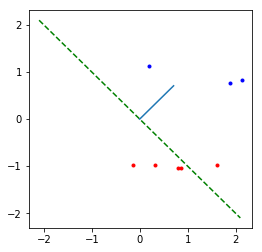

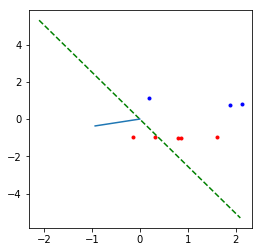

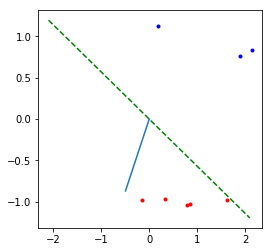

Amostra 3:


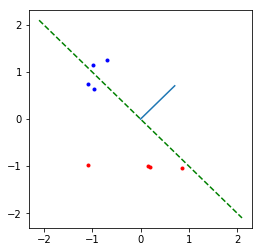

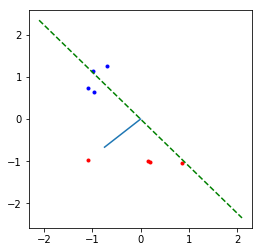

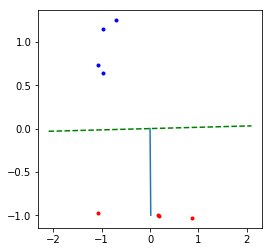

Amostra 4:


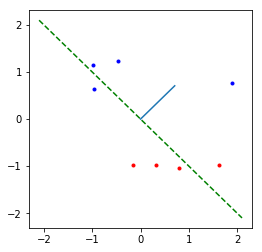

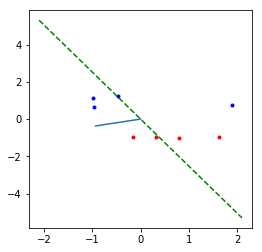

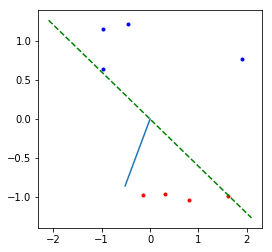

Amostra 5:


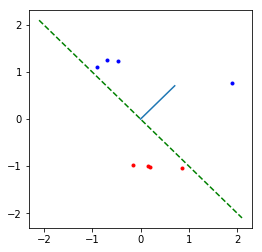

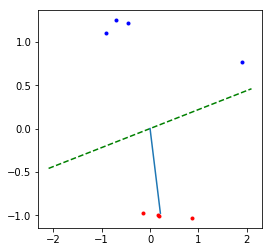

In [234]:
vet_ent = np.empty([n_amostras,2])   #Vetor de amostras de entrada
vet_sdesejadas = np.empty([n_amostras,1])
lista_erros = []

#Geração de amostras e treinamento da rede para fator de aprendizagem = 2
for n in range(5):
    k=0
    print('Amostra {}:'.format(n+1))
    for i in random.sample(range(0,19), n_amostras):    
        vet_ent[k] = rede1.entr_normalizada[i]
        vet_sdesejadas[k,0] = Saida_desejada[i,0]
        #print('{} - {}: {}'.format(vet_ent[k], vet_sdesejadas[k], i))
        k += 1
        
    rede1.set_entradas_pós(vet_ent, normalizar=False)
    rede1.pesos = np.array([[0.1],[0.1]])
    rede1.treinar_rede(2, vet_sdesejadas, 30, True)
        
    lista_erros.append(rede1.historicoErros)

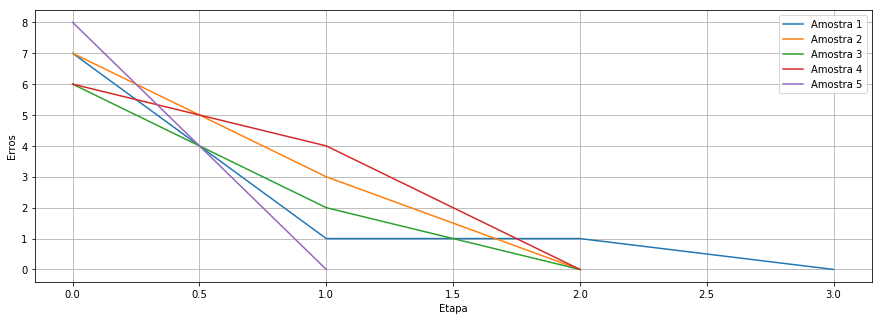

In [235]:
plt.figure(figsize=(15,5))
for k in range(5):
    plt.plot(lista_erros[k], label='Amostra {}'.format(k+1))
plt.xlabel('Etapa')
plt.ylabel('Erros')
plt.legend()
plt.grid(True)
plt.show()

Testando o desempenho da rede para o fator de aprendizagem = 0.02

Amostra 1:


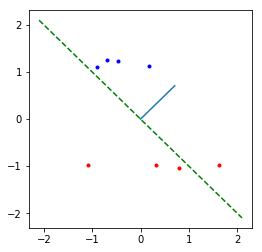

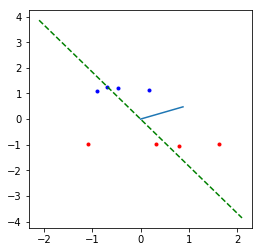

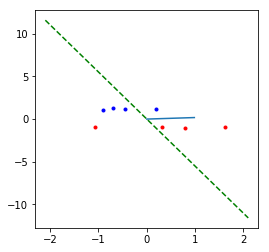

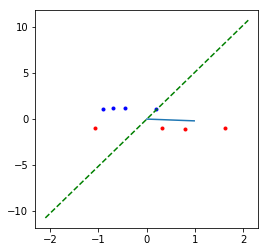

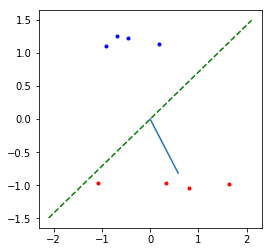

Amostra 2:


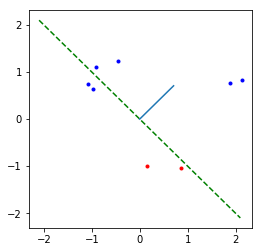

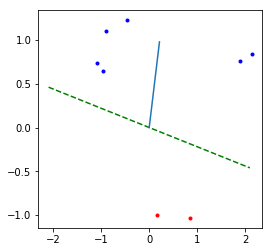

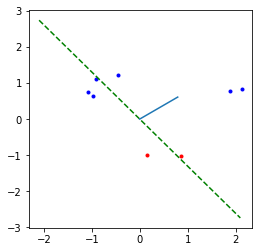

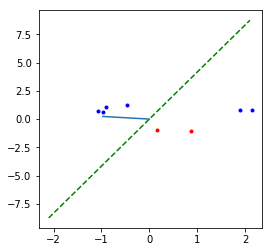

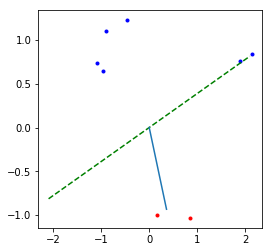

Amostra 3:


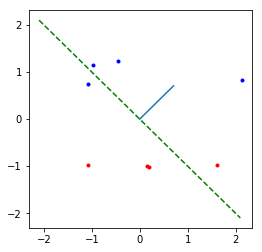

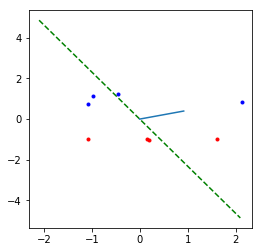

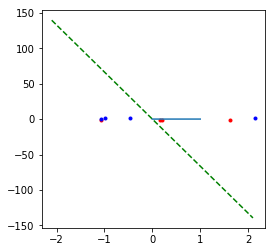

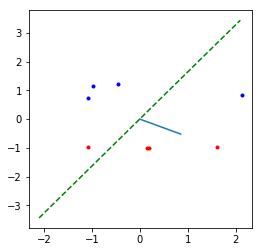

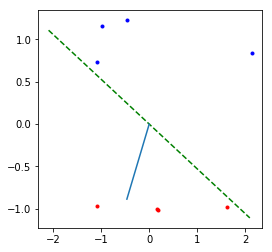

Amostra 4:


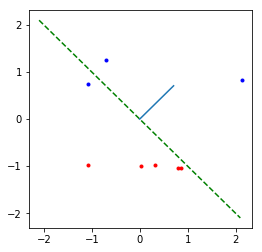

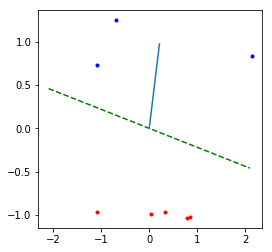

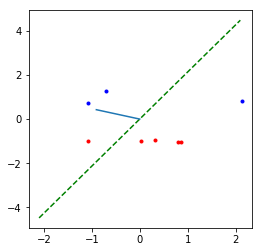

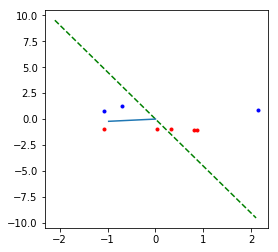

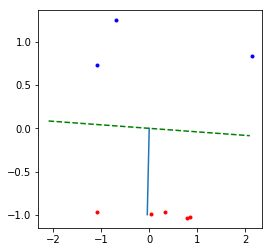

Amostra 5:


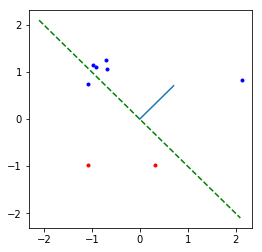

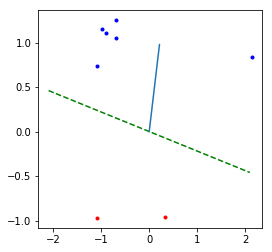

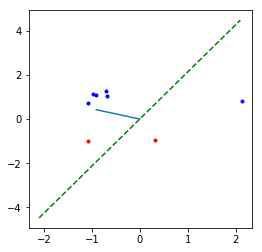

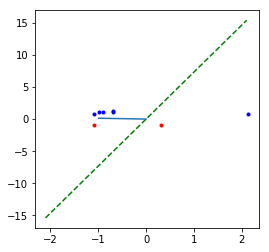

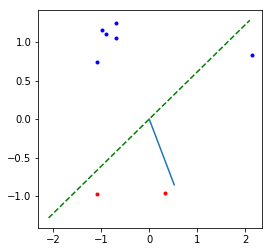

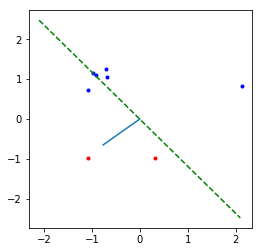

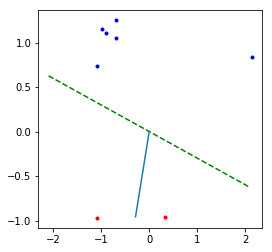

In [236]:
vet_ent = np.empty([n_amostras,2])   #Vetor de amostras de entrada
vet_sdesejadas = np.empty([n_amostras,1])
lista_erros = []

#Geração de amostras e treinamento da rede para fator de aprendizagem = 0.02
for n in range(5):
    k=0
    print('Amostra {}:'.format(n+1))
    for i in random.sample(range(0,19), n_amostras):    
        vet_ent[k] = rede1.entr_normalizada[i]
        vet_sdesejadas[k,0] = Saida_desejada[i,0]
        #print('{} - {}: {}'.format(vet_ent[k], vet_sdesejadas[k], i))
        k += 1
        
    rede1.set_entradas_pós(vet_ent, False)
    rede1.pesos = np.array([[0.1],[0.1]])
    rede1.treinar_rede(0.02, vet_sdesejadas, 30, True)
        
    lista_erros.append(rede1.historicoErros)

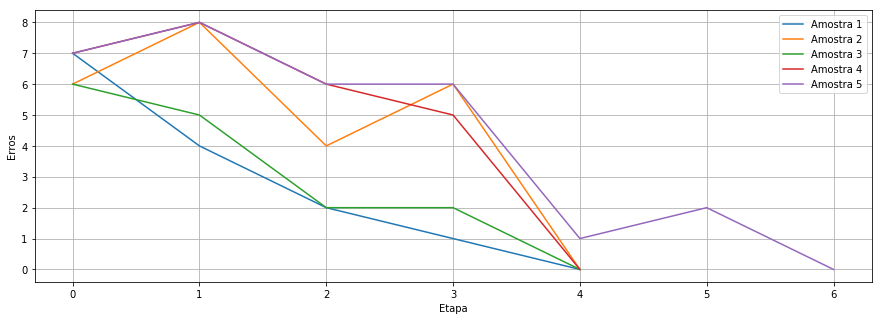

In [237]:
plt.figure(figsize=(15,5))
for k in range(5):
    plt.plot(lista_erros[k], label='Amostra {}'.format(k+1))
plt.xlabel('Etapa')
plt.ylabel('Erros')
plt.legend()
plt.grid(True)
plt.show()

Percebe-se que para valores de $\eta$ muito pequenos a rede demora mais tempo para ser treinada, visto que a velocidade de rotação do vetor de pesos é reduzida. Para valores mais altos a rotação é mais rápida, treinando a rede com uma velocidade maior, porém um valor muito alto de $\eta$ pode tornar o treinamento instável.

## 2.8 Teste da rede neural para novas amostras

Inicialmente a rede neural é treinada utilizando todas as 20 amostras de carros:

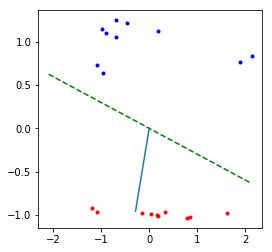

In [238]:
rede1.set_entradas_ant(Entradas, normalizar=True)
rede1.treinar_rede(0.3, Saida_desejada, 30, False)

plotarGrafico(rede1.vetor_entradas, Saida_desejada, rede1.pesos, '')

Novas amostras de carros:

In [239]:
Carros_novos = np.empty((20,3))

#Ford Fusion:
Carros_novos[0] = [44660, 104000, -1]
Carros_novos[1] = [20860, 117800, -1]
Carros_novos[2] = [20000, 118000, -1]
Carros_novos[3] = [19000, 118990, -1]
Carros_novos[4] = [20100, 120900, -1]
Carros_novos[5] = [16000, 125000, -1]
Carros_novos[6] = [30000, 125000, -1]
Carros_novos[7] = [12000, 129900, -1]
Carros_novos[8] = [7000, 130990, -1]
Carros_novos[9] = [9700, 119000, -1]

#Fiat Uno
Carros_novos[10] = [19000, 27990, 1]
Carros_novos[11] = [28000, 30490, 1]
Carros_novos[12] = [35000, 30580, 1]
Carros_novos[13] = [37600, 30790, 1]
Carros_novos[14] = [14000, 30900, 1]
Carros_novos[15] = [66000, 31160, 1]
Carros_novos[16] = [65000, 31000, 1]
Carros_novos[17] = [44000, 31350, 1]
Carros_novos[18] = [45000, 31490, 1]
Carros_novos[19] = [47500, 31490, 1]

Entrada_nova = Carros_novos[:,:2]
Saida_desejada_nova = Carros_novos[:,2]

Testando os novos dados normalizados na rede neural

Carro 1 - Identificado como Fusion
Carro 2 - Identificado como Fusion
Carro 3 - Identificado como Fusion
Carro 4 - Identificado como Fusion
Carro 5 - Identificado como Fusion
Carro 6 - Identificado como Fusion
Carro 7 - Identificado como Fusion
Carro 8 - Identificado como Fusion
Carro 9 - Identificado como Fusion
Carro 10 - Identificado como Fusion
Carro 11 - Identificado como Uno
Carro 12 - Identificado como Uno
Carro 13 - Identificado como Uno
Carro 14 - Identificado como Uno
Carro 15 - Identificado como Uno
Carro 16 - Identificado como Fusion
Carro 17 - Identificado como Fusion
Carro 18 - Identificado como Uno
Carro 19 - Identificado como Uno
Carro 20 - Identificado como Uno


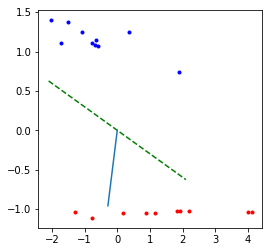

In [240]:
rede1.proc_saida(Entrada_nova, normalizado=False)

for i, el in enumerate(rede1.saida):
    if el == -1:
        print('Carro {} - Identificado como Fusion'.format(i+1))
    else:
        print('Carro {} - Identificado como Uno'.format(i+1))
        
#Plotando gráfico das amostras novas:
Entrada_nova_norm = rede1.normalizar(Entrada_nova, utilizar_parametros_anteriores=True)
plotarGrafico(Entrada_nova_norm, np.transpose([Saida_desejada_nova]), rede1.pesos, '')

18 das 20 novas amostras foram classificadas corretamente. O gráfico acima indica a reta de separação um pouco inclinada, o que ocasionou os erros de classificação. Como alguns dos novos veículos selecionados apresentam quilometragem relativamente maior dos que foram utilizados para treinar a rede ocorreu o erro de interpretação pela rede.

# 3 - Classificação de espécie de plantas

Utilizando a base de dados disponível em http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data, foram criadas 3 redes Perceptron para identificação das plantas. Foram separadas 40% das amostras para treinamento da rede, e o restante foi utilizado para validação.

São 3 tipos de plantas: Iris Setosa, Iris Versicolor e Iris Virginica. 

## 3.1 - Classificação da Iris Setosa

### 3.1.1 - Importação dos dados:

As 4 primeiras colunas dos dados correspondem à características das plantas. A coluna 5 corresponde à saída desejada da rede neural. Saída 1 indica Iris Setosa e -1 indica outra planta.

In [241]:
setosa_treino = np.array([
[5.1,3.5,1.4,0.2,1],
[4.9,3.0,1.4,0.2,1],
[4.7,3.2,1.3,0.2,1],
[4.6,3.1,1.5,0.2,1],
[5.0,3.6,1.4,0.2,1],
[5.4,3.9,1.7,0.4,1],
[4.6,3.4,1.4,0.3,1],
[5.0,3.4,1.5,0.2,1],
[4.4,2.9,1.4,0.2,1],
[4.9,3.1,1.5,0.1,1],
[5.4,3.7,1.5,0.2,1],
[4.8,3.4,1.6,0.2,1],
[4.8,3.0,1.4,0.1,1],
[4.3,3.0,1.1,0.1,1],
[5.8,4.0,1.2,0.2,1],
[5.7,4.4,1.5,0.4,1],
[5.4,3.9,1.3,0.4,1],
[5.1,3.5,1.4,0.3,1],
[5.7,3.8,1.7,0.3,1],
[5.1,3.8,1.5,0.3,1],
[7.0,3.2,4.7,1.4,-1],
[6.4,3.2,4.5,1.5,-1],
[6.9,3.1,4.9,1.5,-1],
[5.5,2.3,4.0,1.3,-1],
[6.5,2.8,4.6,1.5,-1],
[5.7,2.8,4.5,1.3,-1],
[6.3,3.3,4.7,1.6,-1],
[4.9,2.4,3.3,1.0,-1],
[6.6,2.9,4.6,1.3,-1],
[5.2,2.7,3.9,1.4,-1],
[5.0,2.0,3.5,1.0,-1],
[5.9,3.0,4.2,1.5,-1],
[6.0,2.2,4.0,1.0,-1],
[6.1,2.9,4.7,1.4,-1],
[5.6,2.9,3.6,1.3,-1],
[6.7,3.1,4.4,1.4,-1],
[5.6,3.0,4.5,1.5,-1],
[5.8,2.7,4.1,1.0,-1],
[6.2,2.2,4.5,1.5,-1],
[5.6,2.5,3.9,1.1,-1],
[6.3,3.3,6.0,2.5,-1],
[5.8,2.7,5.1,1.9,-1],
[7.1,3.0,5.9,2.1,-1],
[6.3,2.9,5.6,1.8,-1],
[6.5,3.0,5.8,2.2,-1],
[7.6,3.0,6.6,2.1,-1],
[4.9,2.5,4.5,1.7,-1],
[7.3,2.9,6.3,1.8,-1],
[6.7,2.5,5.8,1.8,-1],
[7.2,3.6,6.1,2.5,-1],
[6.5,3.2,5.1,2.0,-1],
[6.4,2.7,5.3,1.9,-1],
[6.8,3.0,5.5,2.1,-1],
[5.7,2.5,5.0,2.0,-1],
[5.8,2.8,5.1,2.4,-1],
[6.4,3.2,5.3,2.3,-1],
[6.5,3.0,5.5,1.8,-1],
[7.7,3.8,6.7,2.2,-1],
[7.7,2.6,6.9,2.3,-1],
[6.0,2.2,5.0,1.5,-1]])

Com os dados importados, é feita a separação dos mesmos em 2 arrays: um de entrada e um de saída.

In [242]:
#Separação do array de dados em array de entradas e saída desejada
setosa_entrada = setosa_treino[:,:4]
setosa_saida_desejada = np.transpose([setosa_treino[:,4]])

### 3.1.2 - Treinamento da rede

Com os dados importados a rede neural é instanciada e treinada para identificação da Iris Setosa:

In [243]:
rede_setosa = Perceptron(4, 'Bipolar', use_bias=True) #Instanciamento da rede

#Define as entradas, faz a normalização e adiciona a coluna p/ bias
rede_setosa.set_entradas_ant(setosa_entrada, True) 
rede_setosa.treinar_rede(0.3, setosa_saida_desejada, 3000, False) #Treinamento, f_aprendizagem = 0.3

### 3.1.3 - Validação

Com a rede treinada, os dados para validação são importados e separados:

In [244]:
setosa_validação = np.array([
[5.4,3.4,1.7,0.2,1],
[5.1,3.7,1.5,0.4,1],
[4.6,3.6,1.0,0.2,1],
[5.1,3.3,1.7,0.5,1],
[4.8,3.4,1.9,0.2,1],
[5.0,3.0,1.6,0.2,1],
[5.0,3.4,1.6,0.4,1],
[5.2,3.5,1.5,0.2,1],
[5.2,3.4,1.4,0.2,1],
[4.7,3.2,1.6,0.2,1],
[4.8,3.1,1.6,0.2,1],
[5.4,3.4,1.5,0.4,1],
[5.2,4.1,1.5,0.1,1],
[5.5,4.2,1.4,0.2,1],
[4.9,3.1,1.5,0.1,1],
[5.0,3.2,1.2,0.2,1],
[5.5,3.5,1.3,0.2,1],
[4.9,3.1,1.5,0.1,1],
[4.4,3.0,1.3,0.2,1],
[5.1,3.4,1.5,0.2,1],
[5.0,3.5,1.3,0.3,1],
[4.5,2.3,1.3,0.3,1],
[4.4,3.2,1.3,0.2,1],
[5.0,3.5,1.6,0.6,1],
[5.1,3.8,1.9,0.4,1],
[4.8,3.0,1.4,0.3,1],
[5.1,3.8,1.6,0.2,1],
[4.6,3.2,1.4,0.2,1],
[5.3,3.7,1.5,0.2,1],
[5.0,3.3,1.4,0.2,1],
[5.9,3.2,4.8,1.8,-1],
[6.1,2.8,4.0,1.3,-1],
[6.3,2.5,4.9,1.5,-1],
[6.1,2.8,4.7,1.2,-1],
[6.4,2.9,4.3,1.3,-1],
[6.6,3.0,4.4,1.4,-1],
[6.8,2.8,4.8,1.4,-1],
[6.7,3.0,5.0,1.7,-1],
[6.0,2.9,4.5,1.5,-1],
[5.7,2.6,3.5,1.0,-1],
[5.5,2.4,3.8,1.1,-1],
[5.5,2.4,3.7,1.0,-1],
[5.8,2.7,3.9,1.2,-1],
[6.0,2.7,5.1,1.6,-1],
[5.4,3.0,4.5,1.5,-1],
[6.0,3.4,4.5,1.6,-1],
[6.7,3.1,4.7,1.5,-1],
[6.3,2.3,4.4,1.3,-1],
[5.6,3.0,4.1,1.3,-1],
[5.5,2.5,4.0,1.3,-1],
[5.5,2.6,4.4,1.2,-1],
[6.1,3.0,4.6,1.4,-1],
[5.8,2.6,4.0,1.2,-1],
[5.0,2.3,3.3,1.0,-1],
[5.6,2.7,4.2,1.3,-1],
[5.7,3.0,4.2,1.2,-1],
[5.7,2.9,4.2,1.3,-1],
[6.2,2.9,4.3,1.3,-1],
[5.1,2.5,3.0,1.1,-1],
[5.7,2.8,4.1,1.3,-1],
[6.9,3.2,5.7,2.3,-1],
[5.6,2.8,4.9,2.0,-1],
[7.7,2.8,6.7,2.0,-1],
[6.3,2.7,4.9,1.8,-1],
[6.7,3.3,5.7,2.1,-1],
[7.2,3.2,6.0,1.8,-1],
[6.2,2.8,4.8,1.8,-1],
[6.1,3.0,4.9,1.8,-1],
[6.4,2.8,5.6,2.1,-1],
[7.2,3.0,5.8,1.6,-1],
[7.4,2.8,6.1,1.9,-1],
[7.9,3.8,6.4,2.0,-1],
[6.4,2.8,5.6,2.2,-1],
[6.3,2.8,5.1,1.5,-1],
[6.1,2.6,5.6,1.4,-1],
[7.7,3.0,6.1,2.3,-1],
[6.3,3.4,5.6,2.4,-1],
[6.4,3.1,5.5,1.8,-1],
[6.0,3.0,4.8,1.8,-1],
[6.9,3.1,5.4,2.1,-1],
[6.7,3.1,5.6,2.4,-1],
[6.9,3.1,5.1,2.3,-1],
[5.8,2.7,5.1,1.9,-1],
[6.8,3.2,5.9,2.3,-1],
[6.7,3.3,5.7,2.5,-1],
[6.7,3.0,5.2,2.3,-1],
[6.3,2.5,5.0,1.9,-1],
[6.5,3.0,5.2,2.0,-1],
[6.2,3.4,5.4,2.3,-1],
[5.9,3.0,5.1,1.8,-1]])

#Separação do array de dados em array de entradas e saída desejada
setosa_entrada_val = setosa_validação[:,:4]
setosa_saida_desejada_val = setosa_validação[:,4]

### 3.1.4 - Resultados

In [260]:
#Define entradas, faz a normalização com base na média e desivo padrão encontrados anteriormente 
#e adiciona coluna p/ bias
rede_setosa.set_entradas_pós(setosa_entrada_val, True)

acertos = 0
for i, el in enumerate(rede_setosa.proc_saida(rede_setosa.vetor_entradas, True)):
    if setosa_saida_desejada_val[i] == el:
        acertos += 1
        
print('Quantidade de acertos: {}'.format(acertos))
print('Percentual de acertos: {}%'.format(acertos*100/(i+1)))

Quantidade de acertos: 89
Percentual de acertos: 98.88888888888889%


No histograma abaixo pode-se observar que a taxa de acerto da rede neural é extremamente alta.

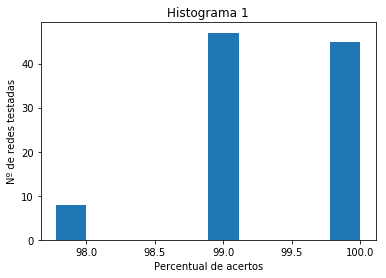

In [246]:
lista_percent_acertos = []
for i in range(100):
    rede_setosa.pesos = np.transpose([(np.random.random_sample(5)-0.5)/3]) #Randomização de pesos
    rede_setosa.set_entradas_ant(setosa_entrada, True) 
    rede_setosa.treinar_rede(0.3, setosa_saida_desejada, 3000, False)    
    rede_setosa.set_entradas_pós(setosa_entrada_val, True)

    acertos = 0
    for i, el in enumerate(rede_setosa.proc_saida(rede_setosa.vetor_entradas, True)):
        if setosa_saida_desejada_val[i] == el:
            acertos += 1
    lista_percent_acertos.append(acertos*100/(i+1))
    
plt.hist(lista_percent_acertos)
plt.xlabel('Percentual de acertos')
plt.ylabel('Nº de redes testadas')
plt.title('Histograma 1')
plt.show()

## 3.2 - Classificação da Iris Versicolor


### 3.2.1 - Importação dos dados:

Assim como nos dados da Iris Setosa, as 4 primeiras colunas dos dados correspondem à características das plantas. A coluna 5 corresponde à saída desejada da rede neural. Saída 1 indica Iris Versicolor e -1 indica outra planta. Os dados importados foram em seguida separados em um vetor de entrada *versicolor_entrada* e de saída desejada *versicolor_sd*

In [247]:
versicolor_treino = np.array([
    [5.1,3.5,1.4,0.2,-1],
    [4.9,3.0,1.4,0.2,-1],
    [4.7,3.2,1.3,0.2,-1],
    [4.6,3.1,1.5,0.2,-1],
    [5.0,3.6,1.4,0.2,-1],
    [5.4,3.9,1.7,0.4,-1],
    [4.6,3.4,1.4,0.3,-1],
    [5.0,3.4,1.5,0.2,-1],
    [4.4,2.9,1.4,0.2,-1],
    [4.9,3.1,1.5,0.1,-1],
    [5.4,3.7,1.5,0.2,-1],
    [4.8,3.4,1.6,0.2,-1],
    [4.8,3.0,1.4,0.1,-1],
    [4.3,3.0,1.1,0.1,-1],
    [5.8,4.0,1.2,0.2,-1],
    [5.7,4.4,1.5,0.4,-1],
    [5.4,3.9,1.3,0.4,-1],
    [5.1,3.5,1.4,0.3,-1],
    [5.7,3.8,1.7,0.3,-1],
    [5.1,3.8,1.5,0.3,-1],
    [7.0,3.2,4.7,1.4,1],
    [6.4,3.2,4.5,1.5,1],
    [6.9,3.1,4.9,1.5,1],
    [5.5,2.3,4.0,1.3,1],
    [6.5,2.8,4.6,1.5,1],
    [5.7,2.8,4.5,1.3,1],
    [6.3,3.3,4.7,1.6,1],
    [4.9,2.4,3.3,1.0,1],
    [6.6,2.9,4.6,1.3,1],
    [5.2,2.7,3.9,1.4,1],
    [5.0,2.0,3.5,1.0,1],
    [5.9,3.0,4.2,1.5,1],
    [6.0,2.2,4.0,1.0,1],
    [6.1,2.9,4.7,1.4,1],
    [5.6,2.9,3.6,1.3,1],
    [6.7,3.1,4.4,1.4,1],
    [5.6,3.0,4.5,1.5,1],
    [5.8,2.7,4.1,1.0,1],
    [6.2,2.2,4.5,1.5,1],
    [5.6,2.5,3.9,1.1,1],
    [6.3,3.3,6.0,2.5,-1],
    [5.8,2.7,5.1,1.9,-1],
    [7.1,3.0,5.9,2.1,-1],
    [6.3,2.9,5.6,1.8,-1],
    [6.5,3.0,5.8,2.2,-1],
    [7.6,3.0,6.6,2.1,-1],
    [4.9,2.5,4.5,1.7,-1],
    [7.3,2.9,6.3,1.8,-1],
    [6.7,2.5,5.8,1.8,-1],
    [7.2,3.6,6.1,2.5,-1],
    [6.5,3.2,5.1,2.0,-1],
    [6.4,2.7,5.3,1.9,-1],
    [6.8,3.0,5.5,2.1,-1],
    [5.7,2.5,5.0,2.0,-1],
    [5.8,2.8,5.1,2.4,-1],
    [6.4,3.2,5.3,2.3,-1],
    [6.5,3.0,5.5,1.8,-1],
    [7.7,3.8,6.7,2.2,-1],
    [7.7,2.6,6.9,2.3,-1],
    [6.0,2.2,5.0,1.5,-1]])

#Separação p/ vetores
versicolor_entrada = versicolor_treino[:,:4]
versicolor_sd = np.transpose([versicolor_treino[:,4]])

### 3.2.2 - Treinamento da rede

Com os dados já importados e separados, agora a rede é instanciada e treinada.

In [248]:
rede_versicolor = Perceptron(4, 'Bipolar', use_bias=True) #Instanciamento
rede_versicolor.set_entradas_ant(versicolor_entrada, normalizar=True) #Processamento das entradas
rede_versicolor.treinar_rede(0.2, versicolor_sd, 3000, False) #Treinamento f_aprendizado=0.3

Nº erros: 15


Percebe-se que o processo de treinamento para identificação da Iris-Versicolor não foi tão efetivo quanto o treinamento da Iris-Setosa. Das 60 amostras utilizadas para o treinamento aproximadamente 15 não foram bem classificadas. Ou seja, 25% das amostras foram classificadas de forma errada. Alterar o fator de aprendizado não surtiu efeito.

### 3.2.3 - Validação

In [249]:
versicolor_val = np.array([
    [5.4,3.4,1.7,0.2,-1],
    [5.1,3.7,1.5,0.4,-1],
    [4.6,3.6,1.0,0.2,-1],
    [5.1,3.3,1.7,0.5,-1],
    [4.8,3.4,1.9,0.2,-1],
    [5.0,3.0,1.6,0.2,-1],
    [5.0,3.4,1.6,0.4,-1],
    [5.2,3.5,1.5,0.2,-1],
    [5.2,3.4,1.4,0.2,-1],
    [4.7,3.2,1.6,0.2,-1],
    [4.8,3.1,1.6,0.2,-1],
    [5.4,3.4,1.5,0.4,-1],
    [5.2,4.1,1.5,0.1,-1],
    [5.5,4.2,1.4,0.2,-1],
    [4.9,3.1,1.5,0.1,-1],
    [5.0,3.2,1.2,0.2,-1],
    [5.5,3.5,1.3,0.2,-1],
    [4.9,3.1,1.5,0.1,-1],
    [4.4,3.0,1.3,0.2,-1],
    [5.1,3.4,1.5,0.2,-1],
    [5.0,3.5,1.3,0.3,-1],
    [4.5,2.3,1.3,0.3,-1],
    [4.4,3.2,1.3,0.2,-1],
    [5.0,3.5,1.6,0.6,-1],
    [5.1,3.8,1.9,0.4,-1],
    [4.8,3.0,1.4,0.3,-1],
    [5.1,3.8,1.6,0.2,-1],
    [4.6,3.2,1.4,0.2,-1],
    [5.3,3.7,1.5,0.2,-1],
    [5.0,3.3,1.4,0.2,-1],
    [5.9,3.2,4.8,1.8,1],
    [6.1,2.8,4.0,1.3,1],
    [6.3,2.5,4.9,1.5,1],
    [6.1,2.8,4.7,1.2,1],
    [6.4,2.9,4.3,1.3,1],
    [6.6,3.0,4.4,1.4,1],
    [6.8,2.8,4.8,1.4,1],
    [6.7,3.0,5.0,1.7,1],
    [6.0,2.9,4.5,1.5,1],
    [5.7,2.6,3.5,1.0,1],
    [5.5,2.4,3.8,1.1,1],
    [5.5,2.4,3.7,1.0,1],
    [5.8,2.7,3.9,1.2,1],
    [6.0,2.7,5.1,1.6,1],
    [5.4,3.0,4.5,1.5,1],
    [6.0,3.4,4.5,1.6,1],
    [6.7,3.1,4.7,1.5,1],
    [6.3,2.3,4.4,1.3,1],
    [5.6,3.0,4.1,1.3,1],
    [5.5,2.5,4.0,1.3,1],
    [5.5,2.6,4.4,1.2,1],
    [6.1,3.0,4.6,1.4,1],
    [5.8,2.6,4.0,1.2,1],
    [5.0,2.3,3.3,1.0,1],
    [5.6,2.7,4.2,1.3,1],
    [5.7,3.0,4.2,1.2,1],
    [5.7,2.9,4.2,1.3,1],
    [6.2,2.9,4.3,1.3,1],
    [5.1,2.5,3.0,1.1,1],
    [5.7,2.8,4.1,1.3,1],
    [6.3,3.3,6.0,2.5,-1],
    [5.8,2.7,5.1,1.9,-1],
    [7.1,3.0,5.9,2.1,-1],
    [6.3,2.9,5.6,1.8,-1],
    [6.5,3.0,5.8,2.2,-1],
    [7.6,3.0,6.6,2.1,-1],
    [4.9,2.5,4.5,1.7,-1],
    [7.3,2.9,6.3,1.8,-1],
    [6.7,2.5,5.8,1.8,-1],
    [7.2,3.6,6.1,2.5,-1],
    [6.5,3.2,5.1,2.0,-1],
    [6.4,2.7,5.3,1.9,-1],
    [6.8,3.0,5.5,2.1,-1],
    [5.7,2.5,5.0,2.0,-1],
    [5.8,2.8,5.1,2.4,-1],
    [6.4,3.2,5.3,2.3,-1],
    [6.5,3.0,5.5,1.8,-1],
    [7.7,3.8,6.7,2.2,-1],
    [7.7,2.6,6.9,2.3,-1],
    [6.0,2.2,5.0,1.5,-1],
    [6.9,3.2,5.7,2.3,-1],
    [5.6,2.8,4.9,2.0,-1],
    [7.7,2.8,6.7,2.0,-1],
    [6.3,2.7,4.9,1.8,-1],
    [6.7,3.3,5.7,2.1,-1],
    [7.2,3.2,6.0,1.8,-1],
    [6.2,2.8,4.8,1.8,-1],
    [6.1,3.0,4.9,1.8,-1],
    [6.4,2.8,5.6,2.1,-1],
    [7.2,3.0,5.8,1.6,-1],
    [7.4,2.8,6.1,1.9,-1],
    [7.9,3.8,6.4,2.0,-1],
    [6.4,2.8,5.6,2.2,-1],
    [6.3,2.8,5.1,1.5,-1],
    [6.1,2.6,5.6,1.4,-1],
    [7.7,3.0,6.1,2.3,-1],
    [6.3,3.4,5.6,2.4,-1],
    [6.4,3.1,5.5,1.8,-1],
    [6.0,3.0,4.8,1.8,-1],
    [6.9,3.1,5.4,2.1,-1],
    [6.7,3.1,5.6,2.4,-1],
    [6.9,3.1,5.1,2.3,-1],
    [5.8,2.7,5.1,1.9,-1],
    [6.8,3.2,5.9,2.3,-1],
    [6.7,3.3,5.7,2.5,-1],
    [6.7,3.0,5.2,2.3,-1],
    [6.3,2.5,5.0,1.9,-1],
    [6.5,3.0,5.2,2.0,-1],
    [6.2,3.4,5.4,2.3,-1],
    [5.9,3.0,5.1,1.8,-1]])

#Separação do array de dados em array de entradas e saída desejada
versicolor_val_entrada = versicolor_treino[:,:4]
versicolor_val_sd = np.transpose([versicolor_treino[:,4]])

### 3.2.4 - Resultados

In [250]:
lista_percent_acertos = []
for i in range(100):
    rede_versicolor.pesos = np.transpose([(np.random.random_sample(5)-0.5)/3]) #Randomização de pesos
    rede_versicolor.set_entradas_ant(versicolor_entrada, True) 
    rede_versicolor.treinar_rede(0.3, versicolor_sd, 100, False)    
    rede_versicolor.set_entradas_pós(versicolor_val_entrada, True)

    acertos = 0
    for i, el in enumerate(rede_versicolor.proc_saida(rede_versicolor.vetor_entradas, True)):
        if versicolor_val_sd[i] == el:
            acertos += 1
    lista_percent_acertos.append(acertos*100/(i+1))

Nº erros: 16
Nº erros: 15
Nº erros: 16
Nº erros: 16
Nº erros: 16
Nº erros: 16
Nº erros: 16
Nº erros: 16
Nº erros: 16
Nº erros: 16
Nº erros: 16
Nº erros: 15
Nº erros: 16
Nº erros: 15
Nº erros: 16
Nº erros: 16
Nº erros: 16
Nº erros: 15
Nº erros: 16
Nº erros: 15
Nº erros: 15
Nº erros: 16
Nº erros: 15
Nº erros: 16
Nº erros: 16
Nº erros: 16
Nº erros: 16
Nº erros: 16
Nº erros: 16
Nº erros: 15
Nº erros: 15
Nº erros: 15
Nº erros: 16
Nº erros: 16
Nº erros: 16
Nº erros: 16
Nº erros: 15
Nº erros: 16
Nº erros: 16
Nº erros: 16
Nº erros: 16
Nº erros: 15
Nº erros: 16
Nº erros: 16
Nº erros: 16
Nº erros: 15
Nº erros: 16
Nº erros: 15
Nº erros: 16
Nº erros: 16
Nº erros: 14
Nº erros: 16
Nº erros: 16
Nº erros: 15
Nº erros: 15
Nº erros: 15
Nº erros: 16
Nº erros: 15
Nº erros: 15
Nº erros: 16
Nº erros: 17
Nº erros: 16
Nº erros: 15
Nº erros: 15
Nº erros: 16
Nº erros: 14
Nº erros: 16
Nº erros: 16
Nº erros: 16
Nº erros: 15
Nº erros: 16
Nº erros: 16
Nº erros: 16
Nº erros: 15
Nº erros: 16
Nº erros: 16
Nº erros: 15

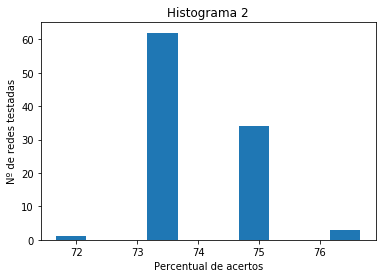

In [251]:
plt.hist(lista_percent_acertos)
plt.xlabel('Percentual de acertos')
plt.ylabel('Nº de redes testadas')
plt.title('Histograma 2')
plt.show()

Percebe-se que devido ao mal treinamento, a capacidade da rede de identificar as plantas Iris-Versicolor foi ruim, apresentando erros em aproximadamente 25% das amostras.

O mal treinamento se deve provavelmente ao fato de não ser possível separar de forma completamente linear as plantas Iris-Versicolor dos outros tipos de plantas.

## 3.3 Classificação da Iris-Virginica

### 3.3.1 - Importação dos dados de entrada

In [252]:
virginica_treino = np.array([
    [5.1,3.5,1.4,0.2,-1],
    [4.9,3.0,1.4,0.2,-1],
    [4.7,3.2,1.3,0.2,-1],
    [4.6,3.1,1.5,0.2,-1],
    [5.0,3.6,1.4,0.2,-1],
    [5.4,3.9,1.7,0.4,-1],
    [4.6,3.4,1.4,0.3,-1],
    [5.0,3.4,1.5,0.2,-1],
    [4.4,2.9,1.4,0.2,-1],
    [4.9,3.1,1.5,0.1,-1],
    [5.4,3.7,1.5,0.2,-1],
    [4.8,3.4,1.6,0.2,-1],
    [4.8,3.0,1.4,0.1,-1],
    [4.3,3.0,1.1,0.1,-1],
    [5.8,4.0,1.2,0.2,-1],
    [5.7,4.4,1.5,0.4,-1],
    [5.4,3.9,1.3,0.4,-1],
    [5.1,3.5,1.4,0.3,-1],
    [5.7,3.8,1.7,0.3,-1],
    [5.1,3.8,1.5,0.3,-1],
    [5.6,2.5,3.9,1.1,-1],
    [5.9,3.2,4.8,1.8,-1],
    [6.1,2.8,4.0,1.3,-1],
    [6.3,2.5,4.9,1.5,-1],
    [6.1,2.8,4.7,1.2,-1],
    [6.4,2.9,4.3,1.3,-1],
    [6.6,3.0,4.4,1.4,-1],
    [6.8,2.8,4.8,1.4,-1],
    [6.7,3.0,5.0,1.7,-1],
    [6.0,2.9,4.5,1.5,-1],
    [5.7,2.6,3.5,1.0,-1],
    [5.5,2.4,3.8,1.1,-1],
    [5.5,2.4,3.7,1.0,-1],
    [5.8,2.7,3.9,1.2,-1],
    [6.0,2.7,5.1,1.6,-1],
    [5.4,3.0,4.5,1.5,-1],
    [6.0,3.4,4.5,1.6,-1],
    [6.7,3.1,4.7,1.5,-1],
    [6.3,2.3,4.4,1.3,-1],
    [5.6,3.0,4.1,1.3,-1],
    [5.5,2.5,4.0,1.3,-1],
    [7.4,2.8,6.1,1.9,1],
    [7.9,3.8,6.4,2.0,1],
    [6.4,2.8,5.6,2.2,1],
    [6.3,2.8,5.1,1.5,1],
    [6.1,2.6,5.6,1.4,1],
    [7.7,3.0,6.1,2.3,1],
    [6.3,3.4,5.6,2.4,1],
    [6.4,3.1,5.5,1.8,1],
    [6.0,3.0,4.8,1.8,1],
    [6.9,3.1,5.4,2.1,1],
    [6.7,3.1,5.6,2.4,1],
    [6.9,3.1,5.1,2.3,1],
    [5.8,2.7,5.1,1.9,1],
    [6.8,3.2,5.9,2.3,1],
    [6.7,3.3,5.7,2.5,1],
    [6.7,3.0,5.2,2.3,1],
    [6.3,2.5,5.0,1.9,1],
    [6.5,3.0,5.2,2.0,1],
    [6.2,3.4,5.4,2.3,1],
    [5.9,3.0,5.1,1.8,1]])

#Separação p/ arrays
virginica_entrada = virginica_treino[:,:4]
virginica_sd = np.transpose([virginica_treino[:,4]])

### 3.3.2 - Treinamento

In [253]:
rede_virginica = Perceptron(4, 'Bipolar', use_bias=True)
rede_virginica.set_entradas_ant(virginica_entrada, True)
rede_virginica.treinar_rede(0.3, virginica_sd, 3000, False)

Nº erros: 3


Das 60 amostras utilizadas para o processo de treinamento, o melhor ajuste de pesos falhou em classificar 2 amostras. Ou seja, uma taxa de erro de 3%.

### 3.3.3 - Validação

In [254]:
virginica_val = np.array([
    [5.4,3.4,1.7,0.2,-1],
    [5.1,3.7,1.5,0.4,-1],
    [4.6,3.6,1.0,0.2,-1],
    [5.1,3.3,1.7,0.5,-1],
    [4.8,3.4,1.9,0.2,-1],
    [5.0,3.0,1.6,0.2,-1],
    [5.0,3.4,1.6,0.4,-1],
    [5.2,3.5,1.5,0.2,-1],
    [5.2,3.4,1.4,0.2,-1],
    [4.7,3.2,1.6,0.2,-1],
    [4.8,3.1,1.6,0.2,-1],
    [5.4,3.4,1.5,0.4,-1],
    [5.2,4.1,1.5,0.1,-1],
    [5.5,4.2,1.4,0.2,-1],
    [4.9,3.1,1.5,0.1,-1],
    [5.0,3.2,1.2,0.2,-1],
    [5.5,3.5,1.3,0.2,-1],
    [4.9,3.1,1.5,0.1,-1],
    [4.4,3.0,1.3,0.2,-1],
    [5.1,3.4,1.5,0.2,-1],
    [5.0,3.5,1.3,0.3,-1],
    [4.5,2.3,1.3,0.3,-1],
    [4.4,3.2,1.3,0.2,-1],
    [5.0,3.5,1.6,0.6,-1],
    [5.1,3.8,1.9,0.4,-1],
    [4.8,3.0,1.4,0.3,-1],
    [5.1,3.8,1.6,0.2,-1],
    [4.6,3.2,1.4,0.2,-1],
    [5.3,3.7,1.5,0.2,-1],
    [5.0,3.3,1.4,0.2,-1],
    [7.0,3.2,4.7,1.4,-1],
    [6.4,3.2,4.5,1.5,-1],
    [6.9,3.1,4.9,1.5,-1],
    [5.5,2.3,4.0,1.3,-1],
    [6.5,2.8,4.6,1.5,-1],
    [5.7,2.8,4.5,1.3,-1],
    [6.3,3.3,4.7,1.6,-1],
    [4.9,2.4,3.3,1.0,-1],
    [6.6,2.9,4.6,1.3,-1],
    [5.2,2.7,3.9,1.4,-1],
    [5.0,2.0,3.5,1.0,-1],
    [5.9,3.0,4.2,1.5,-1],
    [6.0,2.2,4.0,1.0,-1],
    [6.1,2.9,4.7,1.4,-1],
    [5.6,2.9,3.6,1.3,-1],
    [6.7,3.1,4.4,1.4,-1],
    [5.6,3.0,4.5,1.5,-1],
    [5.8,2.7,4.1,1.0,-1],
    [6.2,2.2,4.5,1.5,-1],
    [5.5,2.6,4.4,1.2,-1],
    [6.1,3.0,4.6,1.4,-1],
    [5.8,2.6,4.0,1.2,-1],
    [5.0,2.3,3.3,1.0,-1],
    [5.6,2.7,4.2,1.3,-1],
    [5.7,3.0,4.2,1.2,-1],
    [5.7,2.9,4.2,1.3,-1],
    [6.2,2.9,4.3,1.3,-1],
    [5.1,2.5,3.0,1.1,-1],
    [5.7,2.8,4.1,1.3,-1],
    [6.3,3.3,6.0,2.5,1],
    [5.8,2.7,5.1,1.9,1],
    [7.1,3.0,5.9,2.1,1],
    [6.3,2.9,5.6,1.8,1],
    [6.5,3.0,5.8,2.2,1],
    [7.6,3.0,6.6,2.1,1],
    [4.9,2.5,4.5,1.7,1],
    [7.3,2.9,6.3,1.8,1],
    [6.7,2.5,5.8,1.8,1],
    [7.2,3.6,6.1,2.5,1],
    [6.5,3.2,5.1,2.0,1],
    [6.4,2.7,5.3,1.9,1],
    [6.8,3.0,5.5,2.1,1],
    [5.7,2.5,5.0,2.0,1],
    [5.8,2.8,5.1,2.4,1],
    [6.4,3.2,5.3,2.3,1],
    [6.5,3.0,5.5,1.8,1],
    [7.7,3.8,6.7,2.2,1],
    [7.7,2.6,6.9,2.3,1],
    [6.0,2.2,5.0,1.5,1],
    [6.9,3.2,5.7,2.3,1],
    [5.6,2.8,4.9,2.0,1],
    [7.7,2.8,6.7,2.0,1],
    [6.3,2.7,4.9,1.8,1],
    [6.7,3.3,5.7,2.1,1],
    [7.2,3.2,6.0,1.8,1],
    [6.2,2.8,4.8,1.8,1],
    [6.1,3.0,4.9,1.8,1],
    [6.4,2.8,5.6,2.1,1],
    [7.2,3.0,5.8,1.6,1]])

#Separação p/ arrays
virginica_val_entrada = virginica_val[:,:4]
virginica_val_sd = np.transpose([virginica_val[:,4]])

### 3.3.4 - Resultados

In [255]:
lista_percent_acertos = []
for i in range(100):
    rede_virginica.pesos = np.transpose([(np.random.random_sample(5)-0.5)/3]) #Randomização de pesos
    rede_virginica.set_entradas_ant(virginica_entrada, True) 
    rede_virginica.treinar_rede(0.3, virginica_sd, 100, False)    
    rede_virginica.set_entradas_pós(virginica_val_entrada, True)

    acertos = 0
    for i, el in enumerate(rede_virginica.proc_saida(rede_virginica.vetor_entradas, True)):
        if virginica_val_sd[i] == el:
            acertos += 1
    lista_percent_acertos.append(acertos*100/(i+1))

Nº erros: 2
Nº erros: 2
Nº erros: 2
Nº erros: 2
Nº erros: 2
Nº erros: 2
Nº erros: 2
Nº erros: 2
Nº erros: 2
Nº erros: 2
Nº erros: 2
Nº erros: 2
Nº erros: 2
Nº erros: 2
Nº erros: 2
Nº erros: 2
Nº erros: 2
Nº erros: 2
Nº erros: 2
Nº erros: 2
Nº erros: 3
Nº erros: 2
Nº erros: 2
Nº erros: 2
Nº erros: 2
Nº erros: 2
Nº erros: 2
Nº erros: 2
Nº erros: 2
Nº erros: 2
Nº erros: 2
Nº erros: 2
Nº erros: 2
Nº erros: 2
Nº erros: 2
Nº erros: 2
Nº erros: 2
Nº erros: 2
Nº erros: 2
Nº erros: 2
Nº erros: 2
Nº erros: 2
Nº erros: 2
Nº erros: 3
Nº erros: 2
Nº erros: 2
Nº erros: 2
Nº erros: 2
Nº erros: 2
Nº erros: 2
Nº erros: 2
Nº erros: 2
Nº erros: 2
Nº erros: 2
Nº erros: 2
Nº erros: 2
Nº erros: 2
Nº erros: 2
Nº erros: 2
Nº erros: 2
Nº erros: 2
Nº erros: 2
Nº erros: 2
Nº erros: 2
Nº erros: 2
Nº erros: 2
Nº erros: 2
Nº erros: 2
Nº erros: 2
Nº erros: 2
Nº erros: 2
Nº erros: 2
Nº erros: 2
Nº erros: 2
Nº erros: 2
Nº erros: 2
Nº erros: 2
Nº erros: 3
Nº erros: 2
Nº erros: 2
Nº erros: 2
Nº erros: 2
Nº erros: 2
Nº e

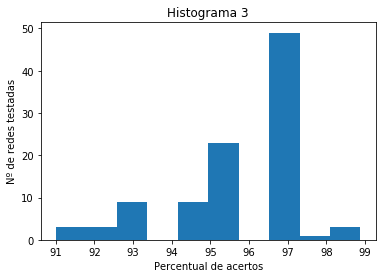

In [256]:
plt.hist(lista_percent_acertos)
plt.xlabel('Percentual de acertos')
plt.ylabel('Nº de redes testadas')
plt.title('Histograma 3')
plt.show()

Devido à baixa quantidade de erros durante o processo de treinamento a rede tem um desempenho muito bom na identificação das Iris-Virginica. Para 100 redes treinadas mais da metade conseguiu uma taxa de acerto de 97%, com algumas alcançando quase 99%.